# Implement Long-short Term Memory(LSTM) in Keras
LSTM is a special kind of recurrent neural network. The major difference between LSTM and RNN is that LSTM has a special mechanism called **forget gate**. As RNNs do, LSTMs also have **hidden state** that would pass to the next time slot. But not like RNN, iformations are selected through the forget gate and only let through those informations that is usefull. Let see how this would help LSTM get away from gradient vanish or gradient explode.

### Input gate in LSTM
First, the input is squashed between -1 and 1 using a tanh activation function. This can be expressed by:

$$g = tanh(b^g+x_tU^g+y_{t-1}V^g)$$

Where **$U^g$** and **$V^g$** are the weights for the input and previous cell output, respectively, and **$b^g$** is the input bias. Note that the exponents **g** are not a raised power, but rather signify that these are the input weights and bias values (as opposed to the input gate, forget gate, output gate etc.).

This squashed input is then multiplied element-wise by the output of the input gate. The input gate is basically a hidden layer of sigmoid activated nodes, with weighted **$x_t$** and **$y_{t-1}$** input values, which outputs values of between 0 and 1 and when multiplied element-wise by the input determines which inputs are switched on and off. In other words, it is a kind of input filter or gate. The expression for the input gate is:

$$i = \sigma(b^i + x_tU^i+ y_{t-1}V^i)$$

### The hidden state and the forget gate
Forget gate is again a sigmoid activated set of nodes which is element-wise multiplied by the hidden state of the previous moment **$s_{t-1}$** to determine which previous states should be remembered (i.e. forget gate output close to 1) and which should be forgotten (i.e. forget gate output close to 0). This allows the LSTM cell to learn appropriate context. The forget gate is like:

$$f = \sigma(b^f + x_tU^f + y_{t-1}V^i)$$

So the hidden state of the current moment is:

$$s_t = s_{t-1}\circ f + g \circ i$$

Where $\circ$ denotes element-wise multiplication.

### The output gate in LSTM

The final stage of the LSTM cell is the output gate. The output gate has two components – another tanh squashing function and an output sigmoid gating function. The output sigmoid gating function, like the other gating functions in the cell, is multiplied by the squashed state st to determine which values of the state are output from the cell. 

The output gate is like:

$$o = \sigma(b^o + x_tU^o + y_{t-1}V^o)$$

So the final output of the cell is:

$$y_t = tanh(s_t)\circ o$$

### Dropout
The **dropout** reduce the chance of overfitting by adding noise to the inputs. It does this by discarding some elements in the input with certain rate $dropout$. 

* For elements which are discarded, **dropout** makes theirs values equal 0.
* For elements which are reserved, **dropout** scales their initial value by $\frac{1}{1-dropout}$.

The summation of the inputs remains unchanged.

# Experiment: airline passenger number prediction
In this experiment, the airline passenger number dataset is used to train a passenger number prediction LSTM network.

In [1]:
# LSTM for international airline passengers problem with regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
numpy.random.seed(7)
dataframe = read_csv('dataset/airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
print('The shape of the dataset is:')
print(dataset.shape)
print('The first 10 elements in the dataset are:')
print(dataset[:10])

The shape of the dataset is:
(144, 1)
The first 10 elements in the dataset are:
[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]]


## Problem setting
We want to use history passenger number of size **look_back**(data from the previous **look_back** months) to predict the passenger number of the next month. We are going to train a MISO(multiple in single out) LSTM network to perform the prediction task.

### Data normalize
LSTMs are very sensitive to the scale of their inputs, especially when using activations like tanh and sigmoid. Imaging this, if the inputs to an activation function are too big or too small, the derivative of tanh or sigmoid activation function would be 0. That means those weights related to that activation won't be updated according to the chain rule.

So, before we feed the raw data into the LSTM network, we need to normalize those inputs and their labels to standard normal distribution as follows:

$$x_i = \frac{x_i - \mu}{\sigma}$$

The same $\mu$ and $\sigma$ will be used again to restore the scale and position of predictions.

$$x_{res} = x_{pre} \times \sigma + \mu$$

In [227]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaleDataset = scaler.fit_transform(dataset)
print('Scaled data:')
print(scaleDataset[:10])

Scaled data:
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]]


### Creating training set and test set

In [228]:
# split into train and test sets
train_size = int(len(scaleDataset) * 0.67)
test_size = len(scaleDataset) - train_size
train_set, test_set = scaleDataset[0:train_size,:], scaleDataset[train_size:len(dataset),:]
print('The size of the training set is:')
print(train_set.shape)
print('The size of the testing set is:')
print(test_set.shape)

The size of the training set is:
(96, 1)
The size of the testing set is:
(48, 1)


### Generate inputs and their labels(targets)

In [225]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [229]:
look_back = 3
trainX, trainY = create_dataset(train_set, look_back)
testX, testY = create_dataset(test_set, look_back)
print('Size of training X:')
print(trainX.shape)
print('Size of training Y:')
print(trainY.shape)
print('Size of testing X:')
print(testX.shape)
print('Size of testing Y:')
print(testY.shape)

Size of training X:
(93, 3)
Size of training Y:
(93,)
Size of testing X:
(45, 3)
Size of testing Y:
(45,)


### Reshape inputs to shape of [samples, time_steps, features]

In [230]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
# trainY = numpy.reshape(trainY, (trainY.shape[0], 1, 1))
# testY = numpy.reshape(testY, (testY.shape[0], 1, 1))
print('Shape of trainX:')
print(trainX.shape)
print('Shape of testX:')
print(testX.shape)
print('Shape of trainY:')
print(trainY.shape)
print('Shape of testY:')
print(testY.shape)
print('The first 5 elements in trainX are:')
print(trainX[:5][:][:])

Shape of trainX:
(93, 3, 1)
Shape of testX:
(45, 3, 1)
Shape of trainY:
(93,)
Shape of testY:
(45,)
The first 5 elements in trainX are:
[[[0.01544401]
  [0.02702703]
  [0.05405405]]

 [[0.02702703]
  [0.05405405]
  [0.04826255]]

 [[0.05405405]
  [0.04826255]
  [0.03281853]]

 [[0.04826255]
  [0.03281853]
  [0.05984557]]

 [[0.03281853]
  [0.05984557]
  [0.08494207]]]


### Setup and train the LSTM network
The network consists of two LSTM networks and a full connected layer. Each of the LSTM layer has 10 hidden units. Two dropout layers are added after each of the LSTM layers. 

In [243]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(10, input_shape = (look_back, 1), return_sequences = True))
model.add(Dropout(0.1))
model.add(LSTM(10, input_shape = (look_back, 10)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=10, verbose=2)

Epoch 1/500
 - 2s - loss: 0.0589
Epoch 2/500
 - 0s - loss: 0.0413
Epoch 3/500
 - 0s - loss: 0.0296
Epoch 4/500
 - 0s - loss: 0.0196
Epoch 5/500
 - 0s - loss: 0.0151
Epoch 6/500
 - 0s - loss: 0.0137
Epoch 7/500
 - 0s - loss: 0.0134
Epoch 8/500
 - 0s - loss: 0.0126
Epoch 9/500
 - 0s - loss: 0.0143
Epoch 10/500
 - 0s - loss: 0.0118
Epoch 11/500
 - 0s - loss: 0.0105
Epoch 12/500
 - 0s - loss: 0.0113
Epoch 13/500
 - 0s - loss: 0.0103
Epoch 14/500
 - 0s - loss: 0.0094
Epoch 15/500
 - 0s - loss: 0.0091
Epoch 16/500
 - 0s - loss: 0.0084
Epoch 17/500
 - 0s - loss: 0.0098
Epoch 18/500
 - 0s - loss: 0.0070
Epoch 19/500
 - 0s - loss: 0.0063
Epoch 20/500
 - 0s - loss: 0.0085
Epoch 21/500
 - 0s - loss: 0.0069
Epoch 22/500
 - 0s - loss: 0.0074
Epoch 23/500
 - 0s - loss: 0.0069
Epoch 24/500
 - 0s - loss: 0.0056
Epoch 25/500
 - 0s - loss: 0.0060
Epoch 26/500
 - 0s - loss: 0.0057
Epoch 27/500
 - 0s - loss: 0.0058
Epoch 28/500
 - 0s - loss: 0.0067
Epoch 29/500
 - 0s - loss: 0.0064
Epoch 30/500
 - 0s - lo

Epoch 239/500
 - 0s - loss: 0.0034
Epoch 240/500
 - 0s - loss: 0.0031
Epoch 241/500
 - 0s - loss: 0.0033
Epoch 242/500
 - 0s - loss: 0.0034
Epoch 243/500
 - 0s - loss: 0.0029
Epoch 244/500
 - 0s - loss: 0.0031
Epoch 245/500
 - 0s - loss: 0.0031
Epoch 246/500
 - 0s - loss: 0.0033
Epoch 247/500
 - 0s - loss: 0.0029
Epoch 248/500
 - 0s - loss: 0.0029
Epoch 249/500
 - 0s - loss: 0.0033
Epoch 250/500
 - 0s - loss: 0.0036
Epoch 251/500
 - 0s - loss: 0.0028
Epoch 252/500
 - 0s - loss: 0.0028
Epoch 253/500
 - 0s - loss: 0.0036
Epoch 254/500
 - 0s - loss: 0.0031
Epoch 255/500
 - 0s - loss: 0.0030
Epoch 256/500
 - 0s - loss: 0.0030
Epoch 257/500
 - 0s - loss: 0.0038
Epoch 258/500
 - 0s - loss: 0.0031
Epoch 259/500
 - 0s - loss: 0.0037
Epoch 260/500
 - 0s - loss: 0.0027
Epoch 261/500
 - 0s - loss: 0.0029
Epoch 262/500
 - 0s - loss: 0.0030
Epoch 263/500
 - 0s - loss: 0.0031
Epoch 264/500
 - 0s - loss: 0.0027
Epoch 265/500
 - 0s - loss: 0.0030
Epoch 266/500
 - 0s - loss: 0.0036
Epoch 267/500
 - 0s 

Epoch 474/500
 - 0s - loss: 0.0023
Epoch 475/500
 - 0s - loss: 0.0019
Epoch 476/500
 - 0s - loss: 0.0021
Epoch 477/500
 - 0s - loss: 0.0021
Epoch 478/500
 - 0s - loss: 0.0022
Epoch 479/500
 - 0s - loss: 0.0020
Epoch 480/500
 - 0s - loss: 0.0020
Epoch 481/500
 - 0s - loss: 0.0023
Epoch 482/500
 - 0s - loss: 0.0022
Epoch 483/500
 - 0s - loss: 0.0022
Epoch 484/500
 - 0s - loss: 0.0023
Epoch 485/500
 - 0s - loss: 0.0024
Epoch 486/500
 - 0s - loss: 0.0023
Epoch 487/500
 - 0s - loss: 0.0021
Epoch 488/500
 - 0s - loss: 0.0024
Epoch 489/500
 - 0s - loss: 0.0019
Epoch 490/500
 - 0s - loss: 0.0015
Epoch 491/500
 - 0s - loss: 0.0021
Epoch 492/500
 - 0s - loss: 0.0019
Epoch 493/500
 - 0s - loss: 0.0020
Epoch 494/500
 - 0s - loss: 0.0021
Epoch 495/500
 - 0s - loss: 0.0020
Epoch 496/500
 - 0s - loss: 0.0025
Epoch 497/500
 - 0s - loss: 0.0022
Epoch 498/500
 - 0s - loss: 0.0025
Epoch 499/500
 - 0s - loss: 0.0019
Epoch 500/500
 - 0s - loss: 0.0019


### Using trained model to make predictions
Using the afore-trained model to make predictions both in the training set and the test set.

In [244]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

### Denormalize of predictions
As we trained the network using normalized data, the datas we predicted are also normalized. Now we want to denormalize them.

In [245]:
# invert predictions
descale_trainPredict = scaler.inverse_transform(trainPredict)
descale_trainY = scaler.inverse_transform([trainY])
descale_testPredict = scaler.inverse_transform(testPredict)
descale_testY = scaler.inverse_transform([testY])
print(descale_testPredict.shape)
print(descale_testPredict[:5, 0])
print(descale_testY.shape)
print(descale_testY[0, :5])

(45, 1)
[369.421   322.89478 350.48102 440.3477  446.94202]
(1, 45)
[348.00001085 355.00000681 421.9999924  465.0000161  466.99998848]


### Calculate the prediction error
RMSE(root mean squared error) for both training set and test set are calculated in the following code:

In [246]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(descale_trainY[0], descale_trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(descale_testY[0], descale_testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 21.36 RMSE
Test Score: 45.65 RMSE


### Discussion: What the rmse would be if using current value as predict valu?

In [214]:
dummy_score = math.sqrt(mean_squared_error(descale_trainY[0][1:], descale_trainY[0][0: descale_trainY.shape[1] -1]))
print('Dummy score:')
print(dummy_score)

Dummy score:
23.6553591573252


### Real value and predicted value visualization

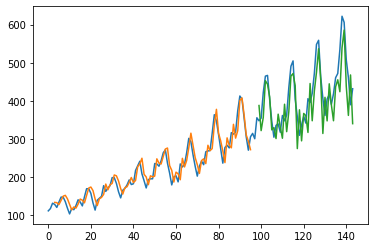

In [215]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = descale_trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = descale_testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

### Keras model .fit .transform .fit_transform
* **.fit** is used to train a model (fit the model to this dataset).
* **.transform(.predict)** is used to processing the data feed into the trained model and generate somthing new.
* **.fit_transform** is a combination of the first two.

Here is a small example of how .fit, .transform and .fit_trnsform work.

First, we have a dataset **data**

In [3]:
data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]

Set a min-max scaler model called **scaler**

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))

Train the model using **data**.

In [5]:
print(scaler.fit(data))

MinMaxScaler(copy=True, feature_range=(0, 1))


Using the trained model to scale inputs.

In [7]:
print(scaler.transform(data))

[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]


Or just using .fit_train would be fine.

In [10]:
print(scaler.fit_transform(data))

[[0.   0.  ]
 [0.25 0.25]
 [0.5  0.5 ]
 [1.   1.  ]]
